In [1]:
from pyspark import SparkContext, SQLContext
sc =SparkContext()

In [39]:
import json
import re

split_regex = r'\W+'

def simpleTokenize(string):
    """ A simple implementation of input string tokenization
    Args:
        string (str): input string
    Returns:
        list: a list of tokens
    """
    return [x for x in re.split(split_regex,string.lower()) if x != '']

dataRddString = sc.textFile("lyrics.json")
dataRdd = (dataRddString
           .map(json.loads)
           .filter(lambda x:(x.get('song') != None and x.get('lyrics') != None))
           .map(lambda x:(x.get('song').split('-'), simpleTokenize(x.get('lyrics')))))
print dataRdd.count()

266556


In [63]:
stopfile = "data/stopwords.txt"
stopwords = set(sc.textFile(stopfile).collect())

def tokenize(wordList):
    return [x for x in wordList if x not in stopwords and len(x)>1]

In [64]:
dataTokenize = (dataRdd
                .map(lambda x: (tokenize(x[0]),tokenize(x[1]),len(x[1])))
                .filter(lambda (x,y,z): (len(x) != 0 and len(y) != 0)))
print dataTokenize.count()

260243


In [65]:
def countFrq(title, lyrics):
    keyCount = {}
    for key in title:
        keyCount[key] = lyrics.count(key)
    return keyCount

In [67]:
titleFrq = dataTokenize.map(lambda (a,b,c): (countFrq(a,b),len(b),c))
print titleFrq.take(1)

[({u'remix': 0, u'ego': 12}, 190, 472)]


In [68]:
# compute the average frequency of titile word in lyrics
allFrq = titleFrq.flatMap(lambda (a,b,c): a.values())
allNum = titleFrq.map(lambda (a,b,c):b)
allNum2= titleFrq.map(lambda (a,b,c):c)
frqSum = allFrq.sum()
numSum = allNum.sum()
numSum2= allNum2.sum()
aveFrq = float(frqSum)/numSum
aveFrq2= float(frqSum)/numSum2
print aveFrq, aveFrq2

0.0898520147703 0.0463198813703


In [69]:
def calFrq(titleDict, length):
    for key in titleDict.keys():
        titleDict[key] = float(titleDict[key])/length
    return titleDict

In [70]:
# compute the highest frequency word
frqRdd = titleFrq.map(lambda (a,b,c): calFrq(a,c))
print frqRdd.take(1)

[{u'remix': 0.0, u'ego': 0.025423728813559324}]


In [71]:
def dictToLists(titleDict):
    titleList = []
    for key in titleDict.keys():
        titleList.append((key,titleDict[key]))
    return titleList

In [72]:
frqRddList = frqRdd.flatMap(dictToLists).filter(lambda x: x[1] != 1.0)
print frqRddList.takeOrdered(5, lambda x: -1*x[1])

[(u'mahna', 0.9473684210526315), (u'allein', 0.8947368421052632), (u'baby', 0.8918918918918919), (u'stickabush', 0.8888888888888888), (u'bot', 0.8461538461538461)]


In [73]:
dataRddYear = (dataRddString
               .map(json.loads)
               .filter(lambda x:(x.get('song') != None and x.get('lyrics') != None and x.get('year') != None))
               .map(lambda x:(x.get('year'), x.get('song').split('-'), simpleTokenize(x.get('lyrics')))))
print dataRddYear.count()
print dataRddYear.take(1)

266556
[(2009, [u'ego', u'remix'], [u'oh', u'baby', u'how', u'you', u'doing', u'you', u'know', u'i', u'm', u'gonna', u'cut', u'right', u'to', u'the', u'chase', u'some', u'women', u'were', u'made', u'but', u'me', u'myself', u'i', u'like', u'to', u'think', u'that', u'i', u'was', u'created', u'for', u'a', u'special', u'purpose', u'you', u'know', u'what', u's', u'more', u'special', u'than', u'you', u'you', u'feel', u'me', u'it', u's', u'on', u'baby', u'let', u's', u'get', u'lost', u'you', u'don', u't', u'need', u'to', u'call', u'into', u'work', u'cause', u'you', u're', u'the', u'boss', u'for', u'real', u'want', u'you', u'to', u'show', u'me', u'how', u'you', u'feel', u'i', u'consider', u'myself', u'lucky', u'that', u's', u'a', u'big', u'deal', u'why', u'well', u'you', u'got', u'the', u'key', u'to', u'my', u'heart', u'but', u'you', u'ain', u't', u'gonna', u'need', u'it', u'i', u'd', u'rather', u'you', u'open', u'up', u'my', u'body', u'and', u'show', u'me', u'secrets', u'you', u'didn', u't', 

In [113]:
dataTokenizeYear = (dataRddYear
                    .map(lambda x: (x[0],tokenize(x[1]),tokenize(x[2]),len(x[2])))
                    .filter(lambda (x,y,z,t): (x > 1900 and len(y) != 0 and len(z) != 0)))
print dataTokenizeYear.count()

260237


In [114]:
titleFrqYear = dataTokenizeYear.map(lambda (a,b,c,d): (a,countFrq(b,c),len(c),d))
print titleFrqYear.takeOrdered(1)

[(1968, {u'without': 3}, 51, 121)]


In [115]:
frqRddYear = (titleFrqYear
              .map(lambda (a,b,c,d): (a,(sum(b.values()),c,d)))
              .reduceByKey(lambda (a,b,c),(x,y,z):(a+x,b+y,c+z)))
print frqRddYear.count()

48


In [116]:
aveFrqRddYear = frqRddYear.map(lambda (a,b):(a,(float(b[0])/b[1],float(b[0])/b[2]))).sortByKey()
print aveFrqRddYear.collect()

[(1968, (0.058823529411764705, 0.024793388429752067)), (1970, (0.1264075803350728, 0.06329287998074741)), (1971, (0.10668085344682758, 0.052066251229911445)), (1972, (0.11179993695492277, 0.05623975897246155)), (1973, (0.1298293867377197, 0.06392568454018367)), (1974, (0.09610011641443539, 0.047909230724587214)), (1975, (0.11568417837507636, 0.05709010061423673)), (1976, (0.1034706454751865, 0.054381179679509034)), (1977, (0.13050284448856478, 0.0655015139320072)), (1978, (0.1281437125748503, 0.06321602876958644)), (1979, (0.1362772335136716, 0.06825838582100484)), (1980, (0.15739745656457102, 0.07767955801104973)), (1981, (0.14216222125054656, 0.07264957264957266)), (1982, (0.13579114993002944, 0.06763447579676009)), (1983, (0.1290603248259861, 0.06515611845235916)), (1984, (0.13855196366550895, 0.06748737702358024)), (1985, (0.14489311163895488, 0.07223422836673674)), (1986, (0.14307733191602445, 0.0713074803983895)), (1987, (0.11404081632653061, 0.05685564283097961)), (1988, (0.1217

In [117]:
years = aveFrqRddYear.map(lambda (a,b):a).collect()
keyFrq = aveFrqRddYear.map(lambda (a,b):b[0]).collect()
totalFrq = aveFrqRddYear.map(lambda (a,b):b[1]).collect()

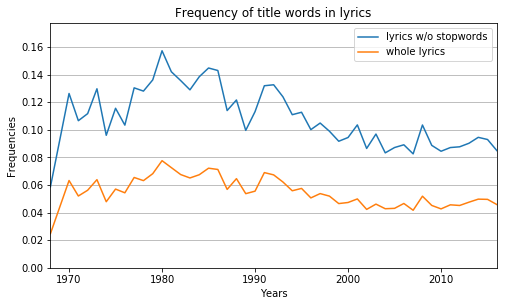

In [138]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(years), max(years), 0, max(keyFrq)+0.02])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Years')
plt.ylabel('Frequencies')
plt.plot(years, keyFrq, label='lyrics w/o stopwords')
plt.plot(years, totalFrq, label='whole lyrics')
plt.title('Frequency of title words in lyrics')
plt.legend()
plt.show()
pass

In [119]:
dataRddGenre = (dataRddString
               .map(json.loads)
               .filter(lambda x:(x.get('song') != None and x.get('lyrics') != None and x.get('genre') != None))
               .map(lambda x:(x.get('genre'), x.get('song').split('-'), simpleTokenize(x.get('lyrics')))))
print dataRddGenre.count()
print dataRddGenre.take(1)

266556
[(u'Pop', [u'ego', u'remix'], [u'oh', u'baby', u'how', u'you', u'doing', u'you', u'know', u'i', u'm', u'gonna', u'cut', u'right', u'to', u'the', u'chase', u'some', u'women', u'were', u'made', u'but', u'me', u'myself', u'i', u'like', u'to', u'think', u'that', u'i', u'was', u'created', u'for', u'a', u'special', u'purpose', u'you', u'know', u'what', u's', u'more', u'special', u'than', u'you', u'you', u'feel', u'me', u'it', u's', u'on', u'baby', u'let', u's', u'get', u'lost', u'you', u'don', u't', u'need', u'to', u'call', u'into', u'work', u'cause', u'you', u're', u'the', u'boss', u'for', u'real', u'want', u'you', u'to', u'show', u'me', u'how', u'you', u'feel', u'i', u'consider', u'myself', u'lucky', u'that', u's', u'a', u'big', u'deal', u'why', u'well', u'you', u'got', u'the', u'key', u'to', u'my', u'heart', u'but', u'you', u'ain', u't', u'gonna', u'need', u'it', u'i', u'd', u'rather', u'you', u'open', u'up', u'my', u'body', u'and', u'show', u'me', u'secrets', u'you', u'didn', u't'

In [121]:
dataTokenizeGenre = (dataRddGenre
                    .map(lambda x: (x[0],tokenize(x[1]),tokenize(x[2]),len(x[2])))
                    .filter(lambda (x,y,z,t): (len(x) != 0 and len(y) != 0 and len(z) != 0)))
print dataTokenizeGenre.count()

260243


In [123]:
titleFrqGenre = dataTokenizeGenre.map(lambda (a,b,c,d): (a,countFrq(b,c),len(c),d))
print titleFrqGenre.take(1)

[(u'Pop', {u'remix': 0, u'ego': 12}, 190, 472)]


In [124]:
frqRddGenre = (titleFrqGenre
              .map(lambda (a,b,c,d): (a,(sum(b.values()),c,d)))
              .reduceByKey(lambda (a,b,c),(x,y,z):(a+x,b+y,c+z)))
print frqRddGenre.count()

12


In [126]:
aveFrqRddGenre = frqRddGenre.map(lambda (a,b):(a,(float(b[0])/b[1],float(b[0])/b[2])))
print aveFrqRddGenre.collect()

[(u'Hip-Hop', (0.05473397631532222, 0.029396803629399917)), (u'Other', (0.08801796094254075, 0.050319336174658905)), (u'Pop', (0.10855234126590411, 0.05608724113445815)), (u'Indie', (0.07837936859443037, 0.03772813394470786)), (u'Country', (0.13151402847048807, 0.06268913068626353)), (u'Electronic', (0.10615545800105636, 0.054073842109673746)), (u'Metal', (0.05692890275204015, 0.030202603729167027)), (u'Rock', (0.0969206141102427, 0.04794580099532924)), (u'Not Available', (0.09760563889742944, 0.05443563326258438)), (u'Jazz', (0.13731081591494781, 0.06945867230501211)), (u'R&B', (0.12416102911984994, 0.05865715040972773)), (u'Folk', (0.08704243113155605, 0.04684960709710724))]


In [127]:
Genre = aveFrqRddGenre.map(lambda (a,b):a).collect()
keyFrq_g = aveFrqRddGenre.map(lambda (a,b):b[0]).collect()
totalFrq_g = aveFrqRddGenre.map(lambda (a,b):b[1]).collect()

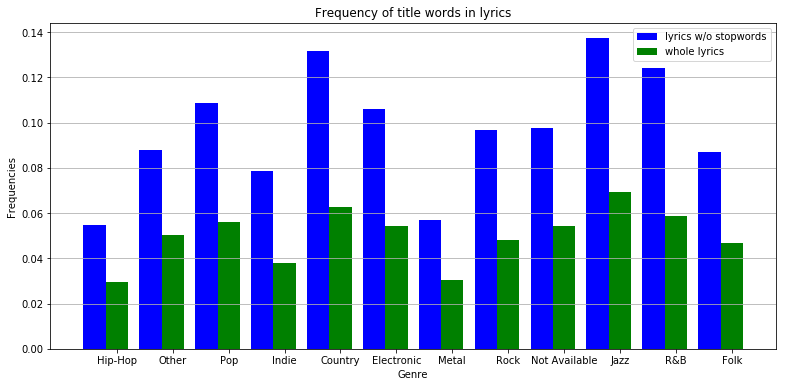

In [139]:
fig = plt.figure(figsize=(13,6), facecolor='white', edgecolor='white')
#plt.axis([min(years), max(years), 0, max(keyFrq)+0.02])
plt.grid(b=True, which='major', axis='y')
barWidth = 0.4
plt.xlabel('Genre')
plt.ylabel('Frequencies')
x = range(len(Genre))
plt.bar(x, keyFrq_g, barWidth, color='b',tick_label = Genre, label = 'lyrics w/o stopwords')
for i in x:
    x[i] = x[i] + barWidth
plt.bar(x, totalFrq_g, barWidth, color='g',tick_label = Genre, label = 'whole lyrics')
plt.title('Frequency of title words in lyrics')
plt.legend()
plt.show()
pass